![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Research to Production
## Kalman Filters and Statistical Arbitrage
---------
### Introduction
This notebook explains how to you can use the Research Environment to develop and test a Kalman Filters and Statistical Arbitrage hypothesis, then put the hypothesis in production.
<a href="https://www.quantconnect.com/docs/v2/research-environment/tutorials/research-to-production/uncorrelated-assets">Documentation</a>

### Create Hypothesis
In finance, we can often observe that 2 stocks with similar background and fundamentals (e.g. AAPL vs MSFT, SPY vs QQQ) move in similar manner. They could be correlated, although not necessary, but their price difference/sum (spread) is stationary. We call this cointegration. Thus, we could hypothesize that extreme spread could provide chance for arbitrage, just like a mean reversion of spread. This is known as pairs trading. Likewise, this could also be applied to more than 2 assets, this is known as statistical arbitrage.

However, although the fluctuation of the spread is stationary, the mean of the spread could be changing by time due to different reasons. Thus, it is important to update our expectation on the spread in order to go in and out of the market in time, as the profit margin of this type of short-window trading is tight. Kalman Filter could come in handy in this situation. We can consider it as an updater of the underlying return Markov Chain's expectation, while we're assuming the price series is a Random Process.

In this example, we're making a hypothesis on trading the spread on cointegrated assets is profitable. We'll be using forex pairs EURUSD, GBPUSD, USDCAD, USDHKD and USDJPY for this example, skipping the normalized price difference selection.

### Import Libraries
We'll need to import packages to help with data processing, model building, validation and visualization. Import arch, pykalman, scipy, statsmodels, numpy, matplotlib and pandas packages by the following:

In [1]:
from arch.unitroot.cointegration import engle_granger
from pykalman import KalmanFilter
from scipy.optimize import minimize
from statsmodels.tsa.vector_ar.vecm import VECM

import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get Historical Data
To begin, we retrieve historical data for research.

In [2]:
# Instantiate a QuantBook.
qb = QuantBook()

# Select the desired tickers for research.
assets = ["EURUSD", "GBPUSD", "USDCAD", "USDHKD", "USDJPY"]

# Call the AddForex method with the tickers, and its corresponding resolution. Then store their Symbols. Resolution.Minute is used by default. 
for i in range(len(assets)):
    qb.AddForex(assets[i],Resolution.Minute)

# Call the History method with qb.Securities.Keys for all tickers, time argument(s), and resolution to request historical data for the symbol.
history = qb.History(qb.Securities.Keys, datetime(2020, 1, 1), datetime(2022, 1, 1), Resolution.Daily)
history

askclose    askhigh     asklow    askopen  \
symbol    time                                                              
USDJPY 8G 2020-01-02 19:00:00  108.55200  108.87200  108.21900  108.67000   
          2020-01-03 19:00:00  108.13800  108.57100  108.00700  108.55200   
          2020-01-05 19:00:00  107.97600  108.13800  107.78000  108.13800   
          2020-01-06 19:00:00  108.41900  108.51200  107.92100  107.97600   
          2020-01-07 19:00:00  108.00400  108.63700  107.83700  108.41900   
...                                  ...        ...        ...        ...   
GBPUSD 8G 2021-12-27 19:00:00    1.34421    1.34476    1.33931    1.34042   
          2021-12-28 19:00:00    1.34349    1.34626    1.34158    1.34424   
          2021-12-29 19:00:00    1.34981    1.35004    1.34098    1.34345   
          2021-12-30 19:00:00    1.34984    1.35229    1.34552    1.34979   
          2021-12-31 19:00:00    1.35386    1.35513    1.34665    1.34984   

                                bidclose    bidhigh     bidlow    bidopen  \
symbol    time                                                              
USDJPY 8G 2020-01-02 19:00:00  108.54000  108.85900  108.20600  108.58800   
          2020-01-03 19:00:00  108.12600  108.55700  107.99400  108.54000   
          2020-01-05 19:00:00  107.96300  108.12600  107.76400  108.12600   
          2020-01-06 19:00:00  108.40500  108.50000  107.90800  107.96300   
          2020-01-07 19:00:00  107.99100  108.62300  107.82400  108.40500   
...                                  ...        ...        ...        ...   
GBPUSD 8G 2021-12-27 19:00:00    1.34403    1.34442    1.33908    1.34015   
          2021-12-28 19:00:00    1.34323    1.34609    1.34140    1.34405   
          2021-12-29 19:00:00    1.34959    1.34988    1.34077    1.34323   
          2021-12-30 19:00:00    1.34958    1.35211    1.34536    1.34956   
          2021-12-31 19:00:00    1.35236    1.35496    1.34646    1.34963   

                                   close        high         low        open  
symbol    time                                                                
USDJPY 8G 2020-01-02 19:00:00  108.54600  108.865500  108.212500  108.629000  
          2020-01-03 19:00:00  108.13200  108.564000  108.000500  108.546000  
          2020-01-05 19:00:00  107.96950  108.132000  107.772000  108.132000  
          2020-01-06 19:00:00  108.41200  108.506000  107.914500  107.969500  
          2020-01-07 19:00:00  107.99750  108.630000  107.830500  108.412000  
...                                  ...         ...         ...         ...  
GBPUSD 8G 2021-12-27 19:00:00    1.34412    1.344590    1.339195    1.340285  
          2021-12-28 19:00:00    1.34336    1.346175    1.341490    1.344145  
          2021-12-29 19:00:00    1.34970    1.349960    1.340875    1.343340  
          2021-12-30 19:00:00    1.34971    1.352200    1.345440    1.349675  
          2021-12-31 19:00:00    1.35311    1.355045    1.346555    1.349735  

[3120 rows x 12 columns]

### Coinegration
We'll have to test if the assets are cointegrated. If so, we'll have to obtain the cointegration vector(s).

#### Cointegration Testing

In [3]:
# Select the close column and then call the unstack method.
data = history['close'].unstack(level=0)

# Convert into log-price series to eliminate compounding effect.
log_price = np.log(data)

# Apply Engle Granger Test to check if the series are cointegrated.
coint_result = engle_granger(log_price.iloc[:, 0], log_price.iloc[:, 1:], trend='n', method='bic')
coint_result

Test Statistic,-4.513
P-value,0.015
ADF Lag length,0
Estimated Root ρ (γ+1),0.946


It shows a p-value < 0.05 for the unit test, with lag-level 0. This proven the log price series are cointegrated in realtime. The spread of the 5 forex pairs are stationary.

#### Get Cointegration Vectors
We would use a VECM model to obtain the cointegrated vectors.

/opt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


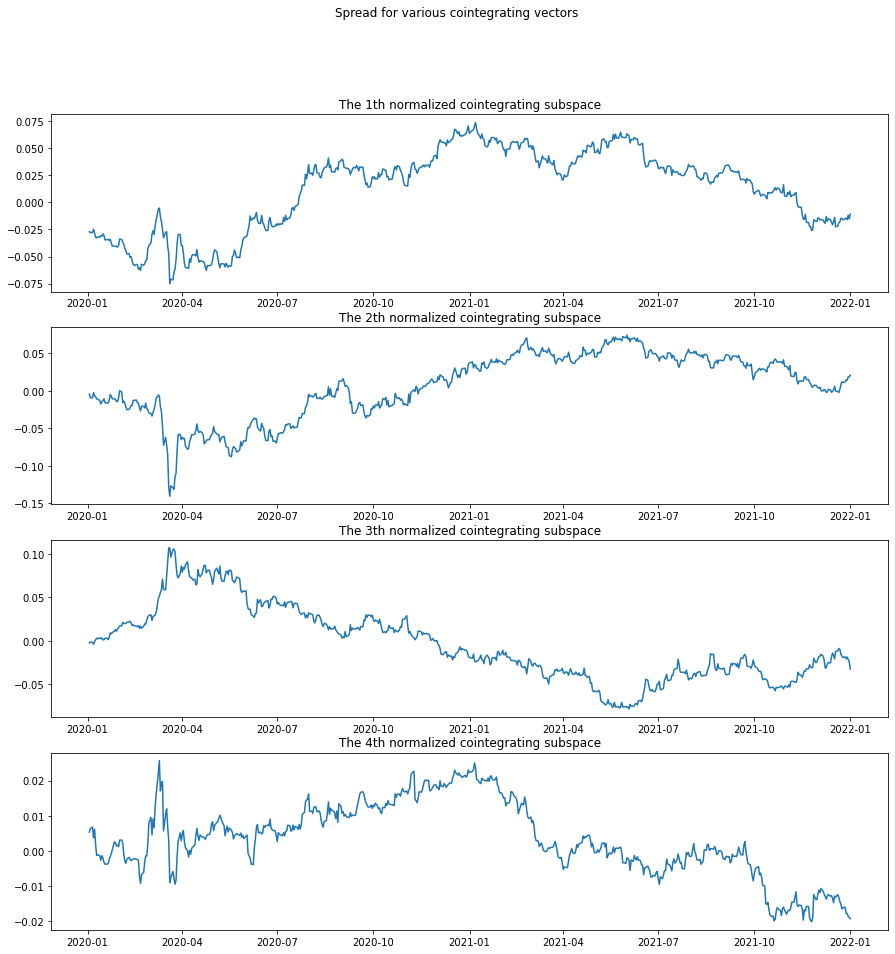

In [4]:
# Initialize a VECM model following the unit test parameters, then fit to our data.
vecm_result = VECM(log_price, k_ar_diff=0, coint_rank=len(assets)-1, deterministic='n').fit()

# Obtain the Beta attribute. This is the cointegration subspaces' unit vectors.
beta = vecm_result.beta

# Check the spread of different cointegration subspaces.
spread = log_price @ beta

# Plot the results.
fig, axs = plt.subplots(beta.shape[1], figsize=(15, 15))
fig.suptitle('Spread for various cointegrating vectors')
for i in range(beta.shape[1]):
    axs[i].plot(spread.iloc[:, i])
    axs[i].set_title(f"The {i+1}th normalized cointegrating subspace")
plt.show()

#### Optimization of Cointegration Subspaces
Although the 4 cointegratoin subspaces are not looking stationarym, we can optimize for a mean-reverting portfolio by putting various weights in different subspaces. We use the Portmanteau statistics as a proxy for the mean reversion. So we formulate:

\begin{equation*}
\begin{aligned}
& \underset{w}{\text{minimize}}
& & \mathrm (\frac {w^{T}M_{1}w} {w^{T}M_{0}w}) ^{2} \\
& \text{subject to}
& & w^{T}M_{0}w = \nu\\
&&& 1^Tw = 0\\
& \text{where}
& & M_i \triangleq Cov(s_t, s_{t+i}) = E[(s_t − E[s_t]) (s_{t+i} − E[s_{t+i}])^T] \\
\end{aligned}
\end{equation*}
<br>
with s is spread, v is predetermined desirable variance level (the larger the higher the profit, but lower the trading frequency)

The weight put on 1th normalized cointegrating subspace: -0.13865147354112853
The weight put on 2th normalized cointegrating subspace: -0.11613044943551973
The weight put on 3th normalized cointegrating subspace: -0.24521807702335174
The weight put on 4th normalized cointegrating subspace: 0.5


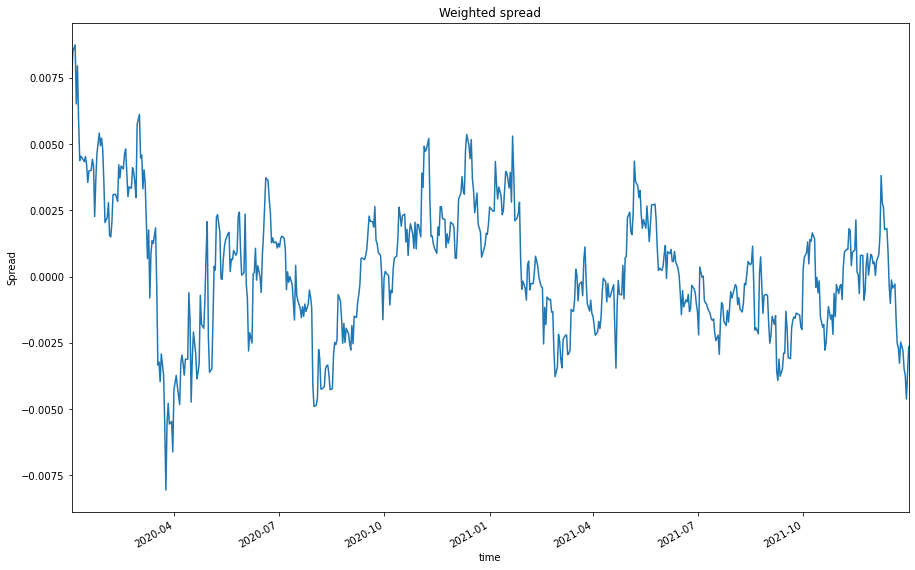

In [5]:
# We set the weight on each vector is between -1 and 1. While overall sum is 0.
x0 = np.array([-1**i/beta.shape[1] for i in range(beta.shape[1])])
bounds = tuple((-1, 1) for i in range(beta.shape[1]))
constraints = [{'type':'eq', 'fun':lambda x: np.sum(x)}]

# Optimize the Portmanteau statistics.
opt = minimize(lambda w: ((w.T @ np.cov(spread.T, spread.shift(1).fillna(0).T)[spread.shape[1]:, :spread.shape[1]] @ w)/(w.T @ np.cov(spread.T) @ w))**2,
               x0=x0,
               bounds=bounds,
               constraints=constraints,
               method="SLSQP")

# Normalize the result.
opt.x = opt.x/np.sum(abs(opt.x))
for i in range(len(opt.x)):
    print(f"The weight put on {i+1}th normalized cointegrating subspace: {opt.x[i]}")
    
# Plot the weighted spread.
new_spread = spread @ opt.x
new_spread.plot(title="Weighted spread", figsize=(15, 10))
plt.ylabel("Spread")
plt.show()

### Kalman Filter
The weighted spread looks more stationary. However, the fluctuation half-life is very long accrossing zero. We aim to trade as much as we can to maximize the profit of this strategy. Kalman Filter then comes into the play. It could modify the expectation of the next step based on smoothening the prediction and actual probability distribution of return.

<img src="https://cdn.quantconnect.com/i/tu/kalman-filter-explained.jpg">
<i>Image Source: Understanding Kalman Filters, Part 3: An Optimal State Estimator. Melda Ulusoy (2017). MathWorks. Retreived from: https://www.mathworks.com/videos/understanding-kalman-filters-part-3-optimal-state-estimator--1490710645421.html</i>

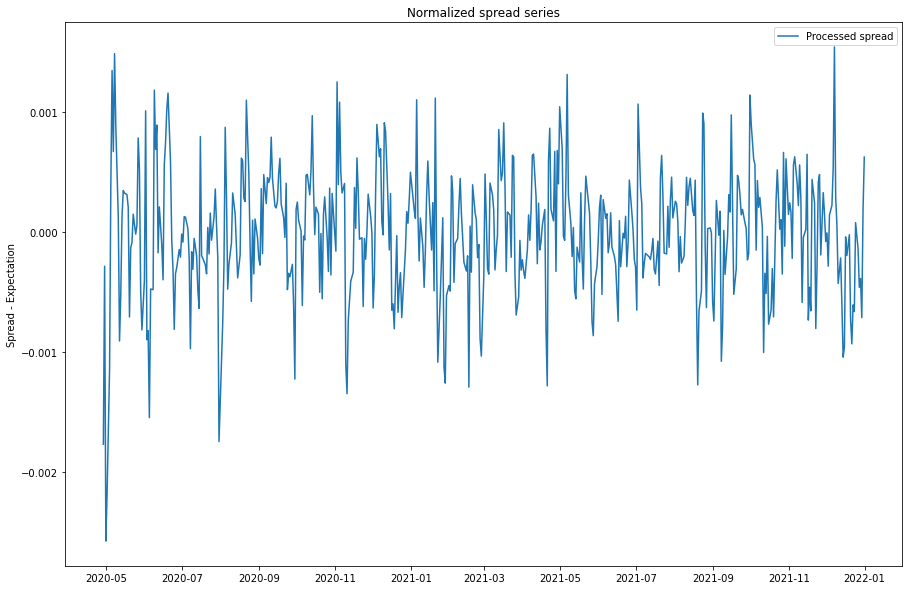

In [6]:
# Initialize a Kalman Filter. Using the first 20 data points to optimize its initial state. We assume the market has no regime change so that the transitional matrix and observation matrix is [1].
kalmanFilter = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = new_spread.iloc[:20].mean(),
                  observation_covariance = new_spread.iloc[:20].var(),
                  em_vars=['transition_covariance', 'initial_state_covariance'])
kalmanFilter = kalmanFilter.em(new_spread.iloc[:20], n_iter=5)
(filtered_state_means, filtered_state_covariances) = kalmanFilter.filter(new_spread.iloc[:20])

# Obtain the current Mean and Covariance Matrix expectations.
currentMean = filtered_state_means[-1, :]
currentCov = filtered_state_covariances[-1, :]

# Initialize a mean series for spread normalization using the Kalman Filter's results.
mean_series = np.array([None]*(new_spread.shape[0]-100))

# Roll over the Kalman Filter to obtain the mean series.
for i in range(100, new_spread.shape[0]):
    (currentMean, currentCov) = kalmanFilter.filter_update(filtered_state_mean = currentMean,
                                                           filtered_state_covariance = currentCov,
                                                           observation = new_spread.iloc[i])
    mean_series[i-100] = float(currentMean)

# Obtain the normalized spread series.
normalized_spread = (new_spread.iloc[100:] - mean_series)

# Plot the normalized spread series.
plt.figure(figsize=(15, 10))
plt.plot(normalized_spread, label="Processed spread")
plt.title("Normalized spread series")
plt.ylabel("Spread - Expectation")
plt.legend()
plt.show()

### Determine Trading Threshold
Now we need to determine the threshold of entry. We want to maximize profit from each trade (variance of spread) x frequency of entry. To do so, we formulate:

\begin{equation*}
\begin{aligned}
& \underset{f}{\text{minimize}}
& & \begin{Vmatrix}
\bar{f} - f
\end{Vmatrix}_{2}^{2} + \lambda\ \begin{Vmatrix}Df\end{Vmatrix}_{2}^{2} \\
& \text{where}
& & \bar{f_j} = \frac{\sum_{t=1}^T 1_{\{spread_t\ >\ set\ level_j\}}}{T}\\
&&& D = \begin{bmatrix}
1 & -1 & & &\\
& 1 & -1 & &\\
&  & \ddots & \ddots & \\
&  &  & 1 & -1
\end{bmatrix} 
\in \mathbb{R}^{(j - 1) \times j}\\
\end{aligned}
\end{equation*}
<br>
so $f^* = (I+\lambda D^TD)^{-1}\bar{f}$ 

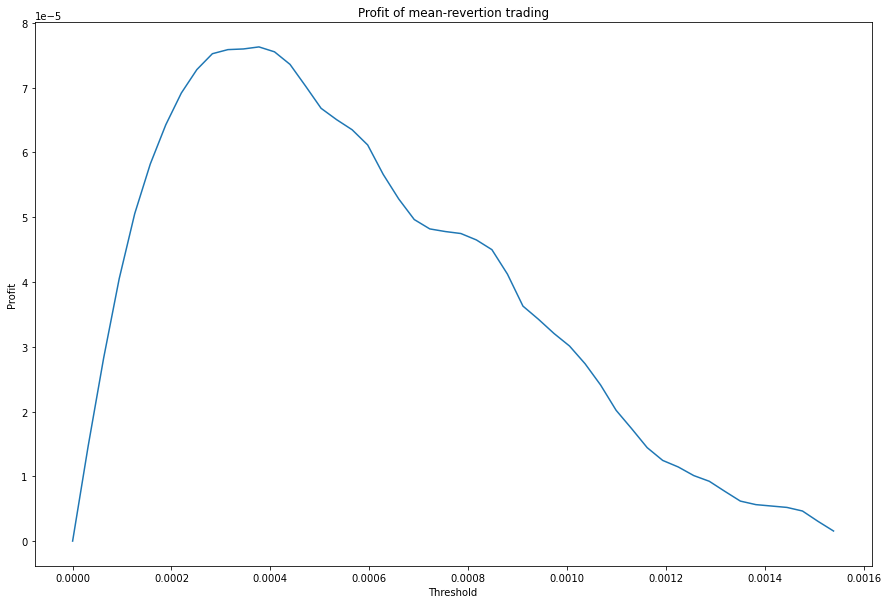

The optimal threshold is 0.00037695228548666345


In [7]:
# Initialize 50 set levels for testing.
s0 = np.linspace(0, max(normalized_spread), 50)

# Calculate the profit levels using the 50 set levels.
f_bar = np.array([None]*50)
for i in range(50):
    f_bar[i] = len(normalized_spread.values[normalized_spread.values > s0[i]]) \
      / normalized_spread.shape[0]
    
# Set trading frequency matrix.
D = np.zeros((49, 50))
for i in range(D.shape[0]):
    D[i, i] = 1
    D[i, i+1] = -1
    
# Set level of lambda.
l = 1.0

# Obtain the normalized profit level.
f_star = np.linalg.inv(np.eye(50) + l * D.T@D) @ f_bar.reshape(-1, 1)
s_star = [f_star[i]*s0[i] for i in range(50)]

# Plot the result.
plt.figure(figsize=(15, 10))
plt.plot(s0, s_star)
plt.title("Profit of mean-revertion trading")
plt.xlabel("Threshold")
plt.ylabel("Profit")
plt.show()

threshold = s0[s_star.index(max(s_star))]
print(f"The optimal threshold is {threshold}")

### Test the Hypothesis
To test the hypothesis. We wish to obtain a profiting strategy.

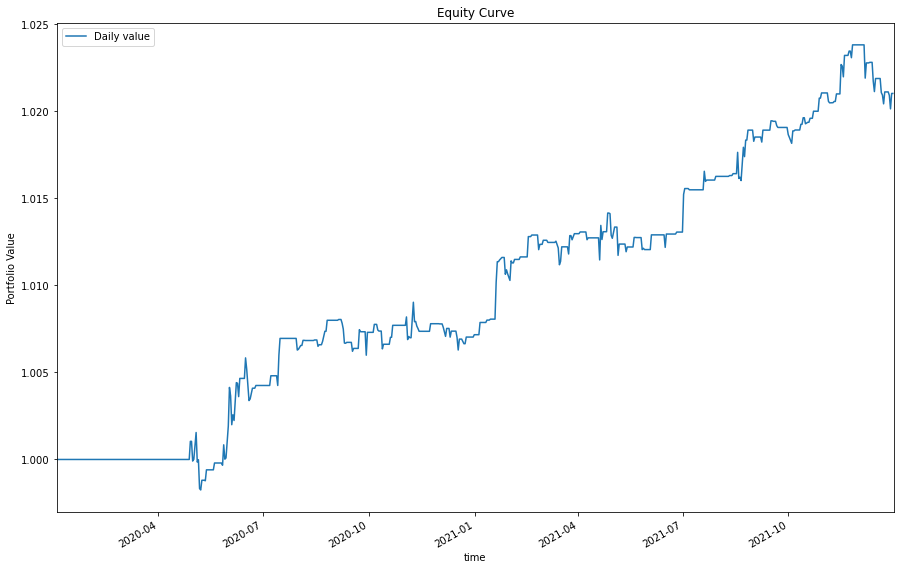

In [8]:
# Set the trading weight. We would like the portfolio absolute total weight is 1 when trading.
trading_weight = beta @ opt.x
trading_weight /= np.sum(abs(trading_weight))

# Set up the trading data.
testing_ret = data.pct_change().iloc[1:].shift(-1)   # Shift 1 step backward as forward return result
equity = pd.DataFrame(np.ones((testing_ret.shape[0], 1)), index=testing_ret.index, columns=["Daily value"])

# Set the buy and sell preiod when the spread exceeds the threshold.
buy_period = normalized_spread[normalized_spread < -threshold].index
sell_period = normalized_spread[normalized_spread > threshold].index

# Trade the portfolio.
equity.loc[buy_period, "Daily value"] = testing_ret.loc[buy_period] @ trading_weight + 1
equity.loc[sell_period, "Daily value"] = testing_ret.loc[sell_period] @ -trading_weight + 1

# Get the total portfolio value.
value = equity.cumprod()

# Plot the result.
value.plot(title="Equity Curve", figsize=(15, 10))
plt.ylabel("Portfolio Value")
plt.show()

### Reference
<ul>
    <li>A Signal Processing Perspective on Financial Engineering. Y. Feng, D. P. Palomer (2016). <i>Foundations and Trends in Signal Processing. 9(1-2).</i> p173-200.</li>
</ul>